Install Dependencies:
run "pip install -r requirements.txt" in the console

In [54]:
#import libraries
from obspy import read
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read example segy file (this ones from the netherlands)
st = read('./data/Seismic_data.sgy', format='SEGY')


In [49]:
inline_length = max(trace.stats.segy.trace_header.trace_sequence_number_within_line for trace in st)
crossline_length = len(st) // (max_inline + 1)
sample_depth_length = len(st[0].data)

print("Inline Length:", inline_length)
print("Crossline Length:", crossline_length)
print("Sample depth length:", sample_depth_length)

Inline Length: 951
Crossline Length: 630
Sample depth length: 462


In [46]:
seismic_3d_array = np.zeros((inline_length + 1, crossline_length + 1, sample_depth_length))

# Populate the 3D array
for i, trace in enumerate(st):
    inline = trace.stats.segy.trace_header.trace_sequence_number_within_line
    crossline = i % (max_crossline + 1)  # Calculate crossline dynamically based on iteration
    seismic_3d_array[inline, crossline, :] = trace.data

In [56]:
#converted to 3d array for easier processing
print(seismic_3d_array.shape)

(952, 631, 462)


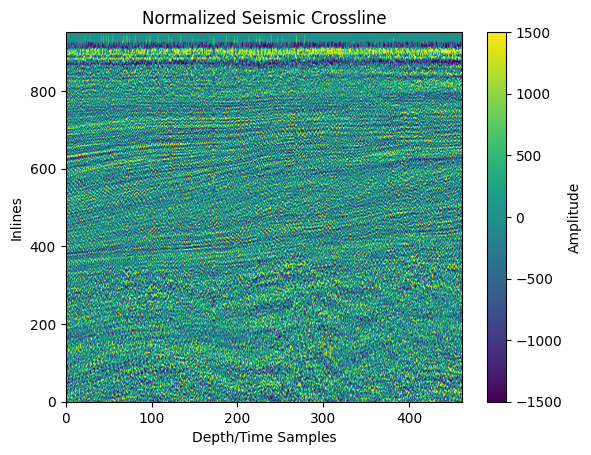

In [78]:
crossline_data = seismic_3d_array[:, 0, :]


clip_threshold = 1500

# Plot the normalized crossline
plt.imshow(np.flipud(np.rot90(np.clip(crossline_data, a_min=-clip_threshold, a_max=clip_threshold))), cmap='viridis', aspect='auto', extent=(0, len(normalized_data[0]), 0, len(normalized_data)))
plt.colorbar(label='Amplitude')
plt.title('Normalized Seismic Crossline')
plt.xlabel('Depth/Time Samples')
plt.ylabel('Inlines')
plt.show()